In [1]:
# !pip install pyshp
import pandas as pd
import pickle
from scipy.spatial import cKDTree
import numpy as np

def read_shapefile(shp_path):
    """
    Read a shapefile into a Pandas dataframe with a 'coords' column holding
    the geometry information. This uses the pyshp package
    """
    import shapefile

    #read file, parse out the records and shapes
    sf = shapefile.Reader(shp_path)
    fields = [x[0] for x in sf.fields][1:]
    records = sf.records()
    shps = [s.points for s in sf.shapes()]

    #write into a dataframe
    df = pd.DataFrame(columns=fields, data=records)
    df = df.assign(coords=shps)

    return df

In [2]:
df = read_shapefile('data/outdoor_inventory/Outdoor_Inventory_AV.shp')

In [3]:
reverse_coords_list = pd.read_pickle('data/reverse_loc.pickle')

In [4]:
df['address_road'] = [x.get('address').get('road') for x in reverse_coords_list]
df['concelho'] = [x.get('address').get('town') for x in reverse_coords_list]
df['freguesia'] = [x.get('address').get('village') if 'village' in x.get('address') else x.get('address').get('neighbourhood') for x in reverse_coords_list]
df['distrito'] = [x.get('address').get('county') for x in reverse_coords_list]

In [5]:
df['address_road'] = df['address_road'].fillna('')
df['is_national_road'] = df['address_road'].str.contains('EN')
df['is_highway'] = df['address_road'].str.contains('Auto')
df['is_city_center'] = (~df['is_national_road']) & (~df['is_highway']) & (df['address_road'] != '')

In [6]:
df.head(3)

,PanelID,X,Y,Max_Visibi,Average_Da,coords,address_road,concelho,freguesia,distrito,is_national_road,is_highway,is_city_center
0,26144,-8.473975,40.900768,69,31.0,"[[-8.473975, 40.900768]]",Rua Alto das Casas,São João da Madeira,Macieira de Sarnes,Aveiro,False,False,True
1,11714,-9.315949,38.958125,69,31.0,"[[-9.315949, 38.958125]]",EN 9,Mafra,Barreiralva,Lisboa,True,False,False
2,26109,-8.510079,40.871821,69,32.0,"[[-8.510079, 40.871821]]",Rua Professor Doutor António Joaquim Ferreira ...,Oliveira de Azeméis,Vila de Cucujães,Aveiro,False,False,True


In [106]:
# https://geoffboeing.com/2014/08/clustering-to-reduce-spatial-data-set-size/
# https://stackoverflow.com/questions/43592094/efficient-way-to-calculate-geographic-density-in-pandas 
# https://stackoverflow.com/questions/34579213/dbscan-for-clustering-of-geographic-location-data 

def find_neighbours_within_radius(xy, radius):
    tree = cKDTree(xy)
    within_radius = tree.query_ball_tree(tree, r=radius)
    return within_radius

In [108]:
def get_density_billboards(df):
    """
    Calculate number of billboards in a X km radius for each point
    """
    
    df_copy = df.copy()

    import numpy as np

    kms_per_radian = 6371.0088
    radius = 1.5
    neighbours_within_radius = find_neighbours_within_radius(
        np.radians(df_copy[['Y', 'X']].values), 
        radius/kms_per_radian
    )

    df_copy['nbr_points_around_billboard'] = [len(x) for x in neighbours_within_radius]

    return df_copy, neighbours_within_radius

In [109]:
df, neighbours_within_radius = get_density_billboards(df)

In [110]:
neighbours_within_radius[0]

[0, 24, 53, 75, 152, 233, 358, 2235, 2363]

In [111]:
from geopy import distance
df.iloc[0][['X', 'Y', 'freguesia']], df.iloc[24][['X', 'Y', 'freguesia']], distance.distance((38.9581, -9.31595), (38.9639, -9.31799))

(X               -9.31595
 Y                38.9581
 freguesia    Barreiralva
 Name: 0, dtype: object,
 X               -9.31799
 Y                38.9639
 freguesia    Barreiralva
 Name: 24, dtype: object,
 Distance(0.6677214916509709))

In [112]:
df['average_people_around_billboard'] = [np.mean(df.iloc[x].Average_Da) for x in neighbours_within_radius]
df['std_people_around_billboard'] = [np.std(df.iloc[x].Average_Da) for x in neighbours_within_radius]

# points where this value is very negative are just visual noise, they make no impact
# retirar N billboards por concelho
df['diff_to_neighbourhood'] = df['Average_Da'] - df['average_people_around_billboard']

# sitios maus: sitios com pouca gente, e que tens muita gente a volta. As pessoas estão a passar pelos outros, e não pelo teu. 
# zonas com muita densidade: estamos a dividir a eficiencia de marketing com outras empresas

# Locais para novos billboards?

In [113]:
df[df.diff_to_neighbourhood < 0].head(3)

,index,PanelID,X,Y,Max_Visibi,Average_Da,coords,address_road,concelho,freguesia,distrito,is_national_road,is_highway,is_city_center,nbr_points_around_billboard,average_people_around_billboard,std_people_around_billboard,diff_to_neighbourhood
0,1,11714,-9.315949,38.958125,69,31.0,"[[-9.315949, 38.958125]]",EN 9,Mafra,Barreiralva,Lisboa,True,False,False,9,998.333333,1228.854028,-967.333333
1,9,34634,-9.143221,38.710728,63,34.0,"[[-9.143221, 38.710728]]",Praça Luís de Camões,None,Encarnação,Lisboa,False,False,True,597,10221.666108,8226.519490,-10187.666108
2,11,4660,-9.420993,38.702024,69,35.0,"[[-9.420993, 38.702024]]",Avenida Dom Pedro I,None,None,Lisboa,False,False,True,161,7139.447205,10393.186544,-7104.447205


In [114]:
df[df.nbr_points_around_billboard > 200].head(3)

,index,PanelID,X,Y,Max_Visibi,Average_Da,coords,address_road,concelho,freguesia,distrito,is_national_road,is_highway,is_city_center,nbr_points_around_billboard,average_people_around_billboard,std_people_around_billboard,diff_to_neighbourhood
1,9,34634,-9.143221,38.710728,63,34.0,"[[-9.143221, 38.710728]]",Praça Luís de Camões,None,Encarnação,Lisboa,False,False,True,597,10221.666108,8226.519490,-10187.666108
6,36,49291,-9.204441,38.710662,71,43.0,"[[-9.204441, 38.710662]]",Avenida Helen Keller,None,None,Lisboa,False,False,True,303,8898.735974,6511.957892,-8855.735974
12,87,13486,-9.229711,38.699057,69,62.0,"[[-9.229711, 38.699057]]",Rua Damião de Góis,None,Baixa de Algés,Lisboa,False,False,True,252,8458.252976,6080.649008,-8396.252976


In [126]:
from matplotlib import pyplot as plt

all_coordinates = df[['Y', 'X']].values

In [124]:
df[['Y', 'X']].values.shape

(12416, 2)

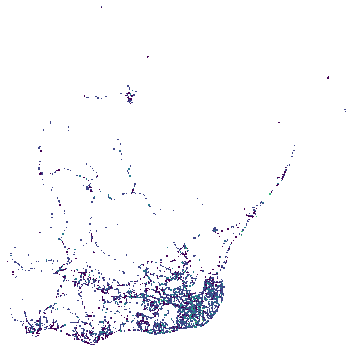

In [139]:
import copy
from matplotlib.colors import LogNorm

def density_map(latitudes, longitudes, center, bins=1000, radius=0.1):  
    cmap = copy.copy(plt.cm.jet)
    cmap.set_bad((0,0,0))  # Fill background with black

    # Center the map around the provided center coordinates
    histogram_range = [
        [center[1] - radius, center[1] + radius],
        [center[0] - radius, center[0] + radius]
    ]
    
    fig = plt.figure(figsize=(5,5))
    plt.hist2d(longitudes, latitudes, bins=bins, norm=LogNorm())#, range=histogram_range)

    # Remove all axes and annotations to keep the map clean and simple
    plt.grid('off')
    plt.axis('off')
    fig.axes[0].get_xaxis().set_visible(False)
    fig.axes[0].get_yaxis().set_visible(False)
    plt.tight_layout()
    plt.show()

    # Coordinates of Porto's city center
porto = [41.1579, -8.6291]
# Separate the latitude and longitude values from our list of coordinates
latitudes = all_coordinates[:,0]
longitudes = all_coordinates[:,1]

# Render the map
density_map(latitudes, longitudes, center=[0, 0])

In [145]:
from folium.plugins import FastMarkerCluster
import folium

m = folium.Map(location=[38.760398,-9.190202], zoom_start=10)

FastMarkerCluster(df[['Y', 'X']].values).add_to(m)

In [153]:
m.to_png('hey.png')

AttributeError: 'Map' object has no attribute 'to_png'

# Metaheuristics: Billboard optimization

In [14]:
# Focus on lisbon

df = df[df['distrito'] == 'Lisboa'].reset_index()

In [15]:
def fitness(df):
    """
    Fitness function, which we want to minimize
    """
    
    # Get billboard density
    df, _ = get_density_billboards(df)

    max_density = df['nbr_points_around_billboard'].mean()
    total_number_of_views = df['Average_Da'].sum()
    return max_density # + total_number_of_views

In [16]:
fitness(df)

382.6084085051546

In [17]:
# We might have different impressions for the same coordinate (maybe diff directions of traffic?) so let's average it out

MEAN_IMPRESSIONS_PER_COORD = df.groupby(['X', 'Y']).Average_Da.mean().reset_index()

In [18]:
df.shape, len(df)

((12416, 18), 12416)

In [19]:
def get_neighbours(df, nbr_neighbours):
    """
    Creates a list of size nbr_neighbours with potential swaps of coordinates.
    
    It first picks random samples from MEAN_IMPRESSIONS_PER_COORD, random positions in df and allocates those values.
    """
    
    neighbors = []
    
    # Pick new positions for swapping random elements of df
    sampled_coords = MEAN_IMPRESSIONS_PER_COORD.sample(nbr_neighbours).reset_index()
    
    for i in range(nbr_neighbours):
        
        df_copy = df.copy()

        # Pick a random number between 0 and len(df)
        random_number = np.random.randint(0, len(df_copy))
                    
        # Replace by the Average_Da at that position
        df_copy.loc[random_number, ['X', 'Y', 'Average_Da']] = sampled_coords.loc[i, ['X', 'Y', 'Average_Da']]
                
        neighbors.append(df_copy)
    
    return neighbors

In [73]:
def shuffle_perturbation(neighbor, prob=0.1):
    """
    Randomly shuffles a subset of positions in the generated neighbors.
    
    It picks a neighbor and generates a new neighbour with some of its positions shuffled according to a given probability.
    """
    
    # Create a copy of the neighbor
    neighbor_copy = neighbor.copy()
    
    # Get the length of this neighbor
    neighbor_len = len(MEAN_IMPRESSIONS_PER_COORD)
    
    # Create a mask of the positions that will shuffle
    mask = np.random.random_sample((neighbor_len,)) <= prob
    mask = np.arange(neighbor_len)[mask]
    
    # Create a shuffled mask to change within these values
    shuffled_mask = mask.copy()
    
    # Shuffle this mask
    np.random.shuffle(shuffled_mask)
    
    # TODO: Create a list with assessed values to avoid "overshuffling"
    
    final_coords = MEAN_IMPRESSIONS_PER_COORD.loc[shuffled_mask]

    # TODO: This is only for debugging purposes for now
    neighbor_copy.loc[mask, ['X', 'Y']] = final_coords[['X', 'Y']].values   

    return neighbor_copy


In [74]:
df2 = shuffle_perturbation(df, prob=0.8)

In [75]:
pd.concat([
    df2.drop(columns=['coords']), 
    df.drop(columns=['coords'])]).drop_duplicates(keep=False)

,index,PanelID,X,Y,Max_Visibi,Average_Da,address_road,concelho,freguesia,distrito,is_national_road,is_highway,is_city_center,nbr_points_around_billboard,average_people_around_billboard,std_people_around_billboard,diff_to_neighbourhood
1,9,34634,-9.210180,38.711315,63,34.0,Praça Luís de Camões,None,Encarnação,Lisboa,False,False,True,597,10221.666108,8226.519490,-10187.666108
3,13,26319,-9.179608,38.709622,69,35.0,Rua da Liberdade,None,None,Lisboa,False,False,True,100,5269.820000,3733.180503,-5234.820000
4,14,26317,-9.145090,38.752849,69,36.0,Rua da Liberdade,None,None,Lisboa,False,False,True,100,5269.820000,3733.180503,-5233.820000
5,19,27178,-9.223913,38.737386,69,37.0,,None,Algueirão-Mem Martins,Lisboa,False,False,False,7,1189.000000,1085.406310,-1152.000000
6,36,49291,-9.150559,38.736586,71,43.0,Avenida Helen Keller,None,None,Lisboa,False,False,True,303,8898.735974,6511.957892,-8855.735974
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11676,28285,20579,-9.071806,38.855212,145,16573.0,Avenida Liberdade,None,None,Lisboa,False,False,True,33,7428.030303,5264.613845,9144.969697
11680,28309,18144,-9.293656,38.772083,69,16644.0,Rua Joaquim Guilherme Costa Caldas,None,Fonte das Eiras,Lisboa,False,False,True,130,9551.438462,7701.108258,7092.561538
11681,28312,18006,-9.250548,38.758723,89,16646.0,Avenida José Elias Garcia,None,Vale de Carenque,Lisboa,False,False,True,178,8254.022472,5542.421762,8391.977528
11682,28315,21276,-9.163855,38.738402,69,16653.0,Rua Basílio Teles,None,None,Lisboa,False,False,True,667,8691.343828,5466.947241,7961.656172


In [77]:
fitness(df), fitness(df2)

(382.6084085051546, 386.1560889175258)

In [61]:
# TODO: Debugging stuff, erase uppon review
# mask = np.random.random_sample((100,)) <= 0.1
# print(mask)
# mask = np.arange(100)[mask]
# shuffled_mask = mask.copy() 
# np.random.shuffle(shuffled_mask)
# mask, shuffled_mask

In [ ]:
fitness(neighbors_it_1[0]), fitness(neighbors_it_1[1]), fitness(neighbors_it_1[3])

Optimization

Gets neighbours in the best solution

In [105]:
best_fitness = np.inf
best_solution = df

history_of_best_solutions = []

for iteration in range(500):
    
    # Get 5 random neighbours
    neighbors = [shuffle_perturbation(best_solution, 0.1)] #get_neighbours(best_solution, 5)
    
    # Get 5 more shuffled neighbours and append to these neighbors list
    #for n in neighbors:
    #    neighbors.append(shuffle_perturbation(n))
    
    # Sanity-check print
    print(f"Nr of possible solutions: {len(neighbors)}.")
    
    
    # Get fitnesses of possible solutions
    fitness_neighbours = [fitness(x) for x in neighbors]
    
    neighbour_lower_fitness_idx = np.argmin(fitness_neighbours)
    fitness_neighbour_lower_fitness = fitness_neighbours[neighbour_lower_fitness_idx]
    neighbour_lower_fitness = neighbors[neighbour_lower_fitness_idx]
    
    if fitness_neighbour_lower_fitness < best_fitness:
        best_fitness = fitness_neighbour_lower_fitness
        best_solution = neighbour_lower_fitness
        
        history_of_best_solutions.append(best_solution)

        print("Found a better solution!")
        
    print("Epoch %d | Fitness %f" % (iteration, best_fitness))

Nr of possible solutions: 1.
Found a better solution!
Epoch 0 | Fitness 383.203608
Nr of possible solutions: 1.
Epoch 1 | Fitness 383.203608
Nr of possible solutions: 1.
Epoch 2 | Fitness 383.203608
Nr of possible solutions: 1.
Epoch 3 | Fitness 383.203608
Nr of possible solutions: 1.
Epoch 4 | Fitness 383.203608
Nr of possible solutions: 1.
Epoch 5 | Fitness 383.203608
Nr of possible solutions: 1.
Epoch 6 | Fitness 383.203608
Nr of possible solutions: 1.
Found a better solution!
Epoch 7 | Fitness 382.435889
Nr of possible solutions: 1.
Epoch 8 | Fitness 382.435889
Nr of possible solutions: 1.
Epoch 9 | Fitness 382.435889
Nr of possible solutions: 1.
Found a better solution!
Epoch 10 | Fitness 380.686856
Nr of possible solutions: 1.
Found a better solution!
Epoch 11 | Fitness 380.420747
Nr of possible solutions: 1.
Found a better solution!
Epoch 12 | Fitness 380.086340
Nr of possible solutions: 1.
Epoch 13 | Fitness 380.086340
Nr of possible solutions: 1.
Epoch 14 | Fitness 380.086340


In [ ]:
best_solution.copy()

Check changes

In [80]:
COLS = ['PanelID', 'X', 'Y', 'Max_Visibi']

In [97]:
diff = pd.concat([df[COLS], best_solution[COLS]]).drop_duplicates(keep=False)
diff.tail(3)

,PanelID,X,Y,Max_Visibi
11682,21276,-9.302795,38.721736,69
11683,8217,-9.090366,38.849433,69
11684,7975,-9.398130,38.703420,69


In [98]:
df[df.PanelID == 21276]['nbr_points_around_billboard']

11682    667
Name: nbr_points_around_billboard, dtype: int64

In [99]:
best_solution[best_solution.PanelID == 21276]['nbr_points_around_billboard']

11682    71
Name: nbr_points_around_billboard, dtype: int64

In [88]:
best_solution, _ = get_density_billboards(best_solution)
df, _ = get_density_billboards(df)

In [84]:
fitness(best_solution)

362.03125

In [85]:
fitness(df)

382.6084085051546

In [ ]:
# Ao trocar da posição (x1, y1) para (x2, y2) estou a ganhar X de audiencia
# O custo médio de aluguer é X€ , mantém se fixo
# assumindo y% das pessoas que vêm têm interesse na marca, estamos a ter um impacto K vezes ... 